# Travel Audience Data Science Challenge #

## Goal ##

One of the main problems we face at travel audience is identifying users that will eventually book a trip to an advertised destination. In this challenge, you are tasked to build a classifier to predict the conversion likelihood of a user based on previous search events, with emphasis on the feature engineering and evaluation part.

## Data ##

You are provided with two sample data sets

- `events.csv.gz` - A sample of events collected from an online travel agency, containing:
  * `ts` - the timestamp of the event
  * `event_type` - either `search` for searches made on the site, or `book` for a conversion, e.g. the user books the flight
  * `user_id` - unique identifier of a user
  * `date_from` - desired start date of the journey
  * `date_to` - desired end date of the journey
  * `origin` - IATA airport code of the origin airport
  * `destination` - IATA airport code of the destination airport
  * `num_adults` - number of adults
  * `num_children` - number of children

- `iata.csv` - containing geo-coordinates of major airports
  * `iata_code` - IATA code of the airport
  * `lat` - latitude in floating point format
  * `lon` - longitude in floating point format

## Tasks ##

Your code needs to do the following:

- Data preparation:
  - Calculate the geographic distance between origins and destinations
  - Convert raw data to a format suitable for the classification task
- Feature_engineering:
  - Based on the given input data, compute and justify three features of your choice that are relevant for predicting converters
- Experimental design:
  - Split data into test and training sets in a meaningful way
- Model:
  - A classifier of your choice that predicts the conversion-likelihood of a user

Use your best judgment to define rules and logic to compute each feature. Don't forget to comment your code!

## Deliverables ##

Code & comments that satisfy the tasks and demonstrate your coding style in Python or R. In addition, instructions on how to run your code.

We'll be evaluating the quality of your code, communication, and general solution design. We won't evaluate the actual performance of your model.

<br>
<br>

### Imports ###

In [1]:
import numpy as np
import pandas as pd
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

<br>
<br>
First, let's load the two datasets, and take a peek at them:

In [2]:
events = pd.read_csv('events.csv')

In [3]:
iata = pd.read_csv('iata_1_1.csv')

In [4]:
events.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0


In [5]:
iata.head()

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70
2,NYC,40.71,-74.01
3,PAR,48.85,2.35
4,IST,41.01,28.95


<br>
<br>
We need to join these two datasets. We'll need to do the join twice - once for the coordinates for the origin airport, once for the coordinates for the destination airport. We'll also rename the columns as appropriate, and drop the ones we don't neeed.

In [6]:
events = events.merge(iata, how='left', left_on='origin', right_on='iata_code')
events.rename(columns={'lat': 'origin_lat', 'lon': 'origin_lon'}, inplace=True)
del events['iata_code']

In [7]:
events = events.merge(iata, how='left', left_on='destination', right_on='iata_code')
events.rename(columns={'lat': 'dest_lat', 'lon': 'dest_lon'}, inplace=True)
del events['iata_code']

<br>
<br>
Let's take a look at the distribution of labels, so as to see what kind of class imbalance we might be working with:

In [8]:
events['event_type'].value_counts(normalize=True)

search    0.960983
book      0.039017
Name: event_type, dtype: float64

Only approximately 4% of the dataset is represented by bookings. This is important to note, as we'll have to take this into account when modeling.

<br>
<br>

### Feature Engineering ###

Now we need to construct some features for the model, as we can't just use the original features. First, we're going to calculate the length of the trip:

In [9]:
events['trip_len'] = (pd.to_datetime(events['date_to']) - pd.to_datetime(events['date_from'])).dt.days

<br>
<br>
Next, we'll calculate the distance of the trip, based on the latitudes and longitudes, using the Haversine formula. The distance is caluclated in kilometers.

In [10]:
events['travel_dist'] = events.apply(lambda x: haversine((x['origin_lat'], x['origin_lon']), (x['dest_lat'], x['dest_lon']), unit=Unit.KILOMETERS), axis=1)

<br>
<br>
Next, we're going to calculate the cumulative counts of the bookings and searches, respectively, for each user over time.

In [11]:
# Sort the dataset by timestamp
events.sort_values('ts',inplace=True)

In [12]:
# Reset the index
events.reset_index(inplace=True)

The idea is to reshape the `even`t column to multiple columns and use `GroupBy.cumcount` per all the groups, with removing missing values with `DataFrame.dropna`, and then forward filling misisng values by `GroupBy.ffill`. Finally, we join this dataframe with the original one using `DataFrame.join`:

In [13]:
counter = events.set_index('event_type', append=True)['user_id'].unstack().add_prefix('num_')
counter = pd.concat([counter.dropna(subset=[c]).groupby(c).cumcount().add(1) 
                                             for c in counter.columns], axis=1, keys=counter.columns)
events = events.join(counter.groupby(events['user_id']).ffill().fillna(0).astype(int))

The trip length has some missing values. Let's impute the mean, as it's the simplest way of going about it:

In [14]:
events['trip_len'].fillna((events['trip_len'].mean()), inplace=True)

<br>
<br>

### Train/Test Split ###

In order to successfully train a model, we can't use the entire dataset. Training and testing a model on the same data can lead to overfitting, as we can't be sure how the model will generalize, i.e. perform on new, unseen data. This is why we split our original dataset into a trainining dataset, used for building a model, and a testing dataset, used for testing the model's performance on new data. Ratio's of 80:20 and 70:30 are common, and here we'll go with 70:30, due to the small number of cases. We'll also set the seed for the random number generator, in order to ensure reproducibility. Finally, we'll opt for stratified sampling, in order to ensure that the distribution of classes in both datasets is as close as possible.

<br>
<br>
As we have a series of events that can be either `search` or `book`, and for a combination of user and journey over time, it gives us a sequence of events. Taking the last instance of that sequence of events, tells us whether it resulted in a booking, or not. 

In [15]:
events_grouped = events.groupby(['user_id', 'origin', 'destination']).tail(1)

In [16]:
events_grouped['event_type'].value_counts()

search    31870
book       1611
Name: event_type, dtype: int64

In [17]:
modeling_df = events_grouped[['num_adults', 'num_children', 'trip_len', 'travel_dist', 'num_book', 'num_search', 'event_type']]

In [18]:
modeling_df.head()

,num_adults,num_children,trip_len,travel_dist,num_book,num_search,event_type
25,1,0,7.0,1851.990822,0,2,search
35,2,0,0.0,934.937884,0,2,search
54,2,0,9.0,8956.000022,0,8,search
55,2,0,4.0,934.937884,1,5,book
75,1,0,0.0,1682.845765,4,12,book


In [19]:
X_train, X_test, y_train, y_test = train_test_split(modeling_df, modeling_df['event_type'],
                                                    test_size=0.3, random_state=176, stratify=modeling_df['event_type'])

In [20]:
X_train = X_train.drop('event_type', axis=1)
X_test = X_test.drop('event_type', axis=1)

<br>
<br>

### Resampling with SMOTE and training a Random Forest model ###

As we're facing a class imbalance in the dataset, we can't just train a model on the data from the outset. This would generate a model which does very well on the negative (majority) class, while very poorly on the positive (minority) class. Here, it's resampling to the rescue. We can generate a synthetic dataset that has the classes balanced out in a better way. Upsampling and downsampling are common techinques, but here we're going to go with a more advanced algorithm - SMOTE (Synthetic Minority Oversampling Technique). Note how we set the radnom state, both for SMOTE and the Random Forest, in order to ensure reproducibility.

In [21]:
# Create the synthetic training data
sm = SMOTE(random_state=205)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [22]:
# Train a Random Forest Classifier and generate predictions
smote_rf = RandomForestClassifier(random_state=366).fit(X_train, y_train)
preds = smote_rf.predict(X_test)

In [23]:
# Calculate accuracy metrics
accuracy = accuracy_score(y_test, preds)
balanced_acc = balanced_accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, pos_label='book')
recall = recall_score(y_test, preds, pos_label='book')
f1 = f1_score(y_test, preds, pos_label='book')

In [24]:
# Prepare the ROC AUC calculation, and calculate
y_test_auc = np.where(y_test == 'book', 1, 0)
preds_auc = np.where(preds == 'book', 1, 0)

auc = roc_auc_score(y_test_auc, preds_auc)

<br>
<br>

### Presenting the results of the Random Forest model ###

Now we're going to create a DataFrame which shows the various accuracy metrics for the model:

In [25]:
metrics = {'Metrics': [accuracy, balanced_acc, precision, recall, f1, auc]}
metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC'])
metrics_df

,Metrics
Accuracy,0.985266
Balanced Accuracy,0.970637
Precision,0.785349
Recall,0.954451
F1 Score,0.861682
AUROC,0.970637


<br>
<br>

### ROC Curve for the SMOTE Random Forest ###

Let's plot the Receiver Operating Characteristic curve for the our model. This curve plots the relationship between the True Positive Rate (a.k.a. Sensitivity) and the False Positive Rate (a.k.a. 1 - Specificity).

In [26]:
fpr, tpr, thresholds = roc_curve(y_test_auc, preds_auc)

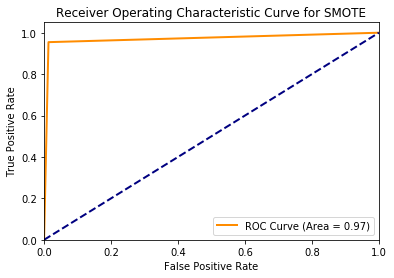

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve (Area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for SMOTE')
plt.legend(loc="lower right")

<br>
<br>

### Feature Importance ###

Finally, let's show the relative importance of the features. Feature importance is calculated by reshuffling the rows of each feature, re-fitting the model and re-predicting, and calculating the drop in accuracy after this is done.

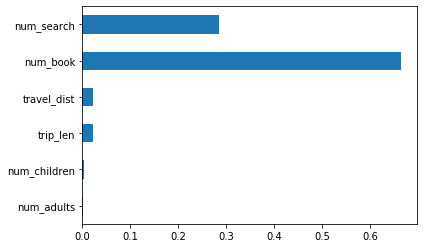

In [28]:
feat_importances = pd.Series(smote_rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')